Import the neccessary libraries

In [13]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import  accuracy_score,classification_report,confusion_matrix,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [14]:
# Define the ticker for Royal Ducth Shell (SHEL is the current tciker for SHEL PLC)
TICKER = "SHEL"
START_DATE = "2010-01-01"
END_DATE = "2024-01-01"

Data Acquisition

In [15]:
print(f"----- Downloading {TICKER} Data -----")
# Download historical stock data using yfinance
# interval= "id" fetches daily data
df = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1d")

----- Downloading SHEL Data -----


C:\Users\Dell\AppData\Local\Temp\ipykernel_10980\1073419033.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1d")
[*********************100%***********************]  1 of 1 completed


In [16]:
df

Price,Close,High,Low,Open,Volume
Ticker,SHEL,SHEL,SHEL,SHEL,SHEL
Date,,,,,
2010-01-04,27.796516,27.818808,27.551319,27.578068,1643003
2010-01-05,27.827728,27.952557,27.658320,27.912434,1718458
2010-01-06,27.600357,27.787600,27.551317,27.702894,3040554
2010-01-07,27.466618,27.502282,27.248168,27.435411,1033089
2010-01-08,27.426493,27.435409,27.159003,27.270457,1438017
...,...,...,...,...,...
2023-12-22,61.264694,61.632417,61.106437,61.460189,3487230
2023-12-26,61.543972,61.776705,61.301927,61.367092,2649997


In [17]:
# Clean up thr index name for plottimg clarity
df.index.name = "Date"

Feature Engineering

In [18]:
# Create the Target Variable (y)
# The goal is to predict if the price will go up (1) or stay the same/go down (0) tomorrow
# We shigft the "Close" price by -1 (one day into a future) to create the target for today's row
df["Target_Movement"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

In [19]:
# Create Technical Indicators (Features X)
# Simple Moving Average - identifies long-term-trend
df["SMA_10"] = df["Close"].rolling(window=10).mean()
df["SMA_50"] = df["Close"].rolling(window=50).mean()

In [20]:
# Relative Strength Index (RSI) - measures momentum, overbrought/oversolid levels
def compute_rsi(data,window=14):
    # Calculate the 14-day Relative Strength Index (RSI)
    # Calculate daily price changes
    delta = data["Close"].diff()

    # Separate gains (up) and loses (down)
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Calculate exponential moving average (EMA) of gains and losses
    avg_gain = gain.ewm(com=window-1,min_periods=window).mean()
    avg_loss = gain.ewm(com=window-1,min_periods=window).mean()

    # Calculate Relative Strength (RS)
    rs = avg_gain /  avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [21]:
df["RSI_14"] = compute_rsi(df)

# Lagged Features - use post price changes as predictors
df["Lagged_Return_1"] = df["Close"].pct_change(1).shift(1) # Yesterday's return
df["Lagged_Return_5"] = df["Close"].pct_change(5).shift(1) # Last week's retrurn

In [22]:
# Drop any rows with NaN values. This is neccessary because of the rolling window and the shift
df.dropna(inplace=True)

Visualization Before Training

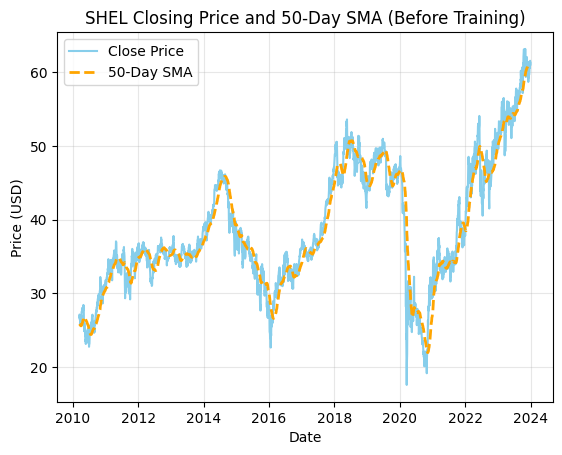

In [23]:
plt.Figure(figsize=(16,6))
# Plot the closing price
plt.plot(df["Close"],label="Close Price",color="skyblue",linewidth=1.5)
# Plot  the 50-day Simple Moving Average for trend comparison
plt.plot(df["SMA_50"],label="50-Day SMA",color="orange",linestyle="--",linewidth=2)
plt.title(f"{TICKER} Closing Price and 50-Day SMA (Before Training)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True,alpha=0.3)
plt.show()

In [24]:
'''# Visualize the distribution of the Target Variable (Up vs Down days)
plt.Figure(figsize=(8,5))
df["Target_Movement"].value_counts().plot(kind="bar",color=["darkred","darkgreen"])
plt.title("Distribution of Target Movement (0=Down/Same, 1=Up)")
plt.xlabel("Movement")
plt.ylabel("Count")
plt.xticks(ticks=[0,1],labels=["Down/Same (0)","Up (1)"],rotation=0)
plt.grid(axis="y",alpha=0.5)
plt.show()'''

'# Visualize the distribution of the Target Variable (Up vs Down days)\nplt.Figure(figsize=(8,5))\ndf["Target_Movement"].value_counts().plot(kind="bar",color=["darkred","darkgreen"])\nplt.title("Distribution of Target Movement (0=Down/Same, 1=Up)")\nplt.xlabel("Movement")\nplt.ylabel("Count")\nplt.xticks(ticks=[0,1],labels=["Down/Same (0)","Up (1)"],rotation=0)\nplt.grid(axis="y",alpha=0.5)\nplt.show()'

Feature Engineering

In [25]:
# Define the features (X) and target (y)
features = ["Close","Volume","SMA_10","SMA_50","RSI_14","Lagged_Return_1","Lagged_Return_5"]
X = df[features]
y = df["Target_Movement"]

Data Splitting 

In [26]:
# Split the data into training and testing sets (80% train, 20% test)
# Cruically, we use shuffle=False to maintain the time-series order, avoiding data leakage
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 2778 samples
Testing set size: 695 samples


Data Scaling

In [27]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data to prevent data leakage from the test set
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation (fitted on training data) to the test data
X_test_scaled = scaler.transform(X_test)

Model Training, Comparison and Evaluation

In [28]:
# Dictionary to store all models for comparison
models = {
    "Logistic Regression":LogisticRegression(random_state=42,solver="liblinear"),
    "K-Nearest Neighbors":KNeighborsClassifier(),
    "Support Vector Machine (Linear)":SVC(kernel="linear",random_state=42,probability=True),
    "Random Forest":RandomForestClassifier(random_state=42)
}

results = {} # Dictionary to store all models performance metrics

In [29]:
print("----- Model Comparison Results -----")

# Loop through each model,train it and evaluate its performance
for name,model in models.items():
    # Tran the model using the scaled training data
    model.fit(X_train_scaled,y_train)

    # Make predictions on the scaled test data
    y_pred = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test,y_pred)

    # Store the results
    results[name] = accuracy

    # Print the evaluation
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"Classification Report for {name}: {classification_report(y_test,y_pred,zero_division=0)}")


# Find the best model based on accuracy
best_model_name = max(results,key=results.get)
print(f"-----  Best Model Before Tuning: {best_model_name} (Accuracy: {results[best_model_name]:.4f})")

----- Model Comparison Results -----
Logistic Regression Accuracy: 0.5022
Classification Report for Logistic Regression:               precision    recall  f1-score   support

           0       0.47      0.33      0.39       333
           1       0.52      0.66      0.58       362

    accuracy                           0.50       695
   macro avg       0.49      0.50      0.48       695
weighted avg       0.50      0.50      0.49       695

K-Nearest Neighbors Accuracy: 0.4950
Classification Report for K-Nearest Neighbors:               precision    recall  f1-score   support

           0       0.48      0.57      0.52       333
           1       0.52      0.43      0.47       362

    accuracy                           0.49       695
   macro avg       0.50      0.50      0.49       695
weighted avg       0.50      0.49      0.49       695

Support Vector Machine (Linear) Accuracy: 0.5209
Classification Report for Support Vector Machine (Linear):               precision    recall

Hyperparameter Tuning (Grid Search on Random Forest)

In [30]:
# Define the model and the parameter grid to search
rf_model = RandomForestClassifier(random_state=42)
param_grid = {
    # Number of trees in the forest
    "n_estimators":[100,200],
    # Maximum number of features considered for splitting a node
    "max_features":["sqrt"],
    # Maximum depth of the tree
    "max_depth":[10,20,None],
    # Minimum number of samples required to split an internal node
    "min_samples_split":[5,10]
}

In [31]:
# Initialize GridSearchCV with the model,parameter grid, and 5-fold cross-valiadtion (cv=5)
# verbose=2 prints detailed outpurts
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

In [32]:
# Fit GridSearchCV to the traning data. This runs the search process.
grid_search.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [10, 20, ...], 'max_features': ['sqrt'], 'min_samples_split': [5, 10], 'n_estimators': [100, 200]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [33]:
# Get the best estimator (model with optimal hyperparameters)
best_rf_model = grid_search.best_estimator_

In [34]:
print(f'Best Hyperparameters found: {grid_search.best_params_}')

# Evaluate the tuned model on the test  set
y_pred_tuned = best_rf_model.predict(X_test_scaled)
tuned_accuracy = accuracy_score(y_test,y_pred_tuned)

Best Hyperparameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}


In [35]:
print(f"Tuned Random Forest Accuracy: {tuned_accuracy:.4f}")
print(f"Classification Report for Tuned Forest: {classification_report(y_test,y_pred_tuned,zero_division=0)}")

Tuned Random Forest Accuracy: 0.4921
Classification Report for Tuned Forest:               precision    recall  f1-score   support

           0       0.48      0.59      0.52       333
           1       0.52      0.41      0.45       362

    accuracy                           0.49       695
   macro avg       0.50      0.50      0.49       695
weighted avg       0.50      0.49      0.49       695



Visualization After Training

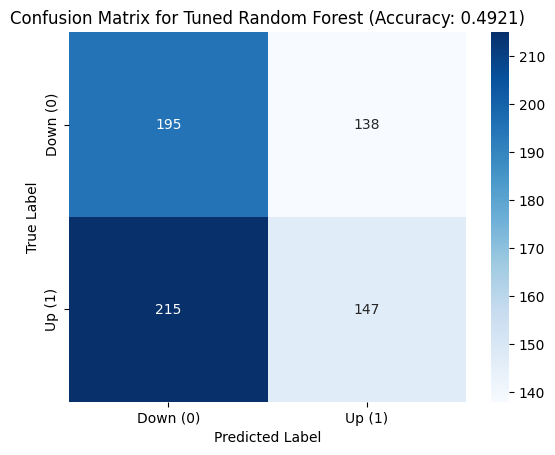

In [36]:
# Confusion Matric for the best tuned model (Random Forest)
cm = confusion_matrix(y_test,y_pred_tuned)
plt.Figure(figsize=(8,6))
# Use seaborn to visualize the confusion matrix with annotations
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=["Down (0)","Up (1)"],yticklabels=["Down (0)","Up (1)"])
plt.title(f'Confusion Matrix for Tuned Random Forest (Accuracy: {tuned_accuracy:.4f})')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

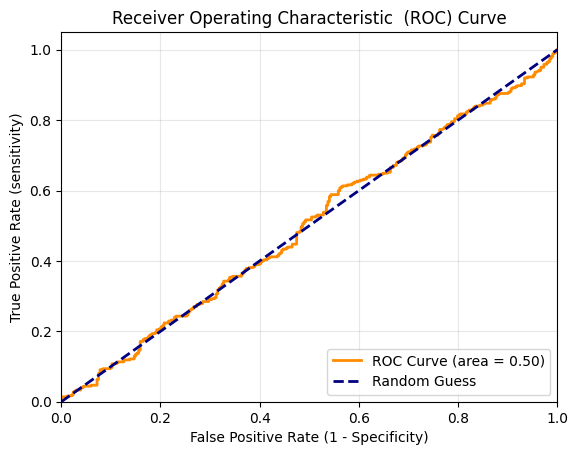

In [37]:
# ROC Curve for the best model tuned model
# For Random Forest, we use predict_proba to get probablity estimates for the ROC curve
y_probs = best_rf_model.predict_proba(X_test_scaled)[:,1] # Probability of class 1 9Up
fpr, tpr, thresholds = roc_curve(y_test,y_probs)
roc_auc = auc(fpr,tpr)

plt.Figure(figsize=(8,6))
plt.plot(fpr,tpr,color="darkorange",lw=2,label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0,1],[0,1],color="navy",lw=2,linestyle="--",label="Random Guess")
plt.xlim([0.0,1.0])
plt.ylim(0.0,1.05)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (sensitivity)")
plt.title('Receiver Operating Characteristic  (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True,alpha=0.3)
plt.show()

Prediction Fucntion (New Input)

In [38]:
def predict_new_day(model,scaler,current_close,current_volume,current_sma10,current_sma50,current_rsi14,lagged_ret1,lagged_ret5):
    """
    Takes user input and predicts the next day's movement.
    NOTE: In a real-world scenario, you would calculate SMA/RSI based on current market data,
    but here we accept the calculated features for simplicity.
    """
    # Create a DataFrame from the new input data
    new_data = pd.DataFrame({
        "Close":[current_close],
        "Volume":[current_volume],
        "SMA_10":[current_sma10],
        "SMA_50":[current_sma50],
        "RSI_14":[current_rsi14],
        "Lagged_Return_1":[lagged_ret1],
        "Lagged_Return_5":[lagged_ret5]
    })

    # Scale the new data using the fitted scaler (CRITICAL STEP)
    new_data_scaled = scaler.transform(new_data)

    # Make the prediction
    prediction = model.predict(new_data_scaled)[0]

    # Get the probability for both classes
    probabilities = model.predict_proba(new_data_scaled)[0]

    # Interpret the prediction
    if prediction == 1:
        result = "UP"
        prob = probabilities[1]
    else:
        result = "DOWN/SAME"
        prob = probabilities[0]


    print("----- New Prediction -----")
    print(f"Predicted Movement: {result}")
    print(f'Confidence Score: {prob:.4f}')

    return prediction

In [ ]:
# Example usage of the prediction Function:
# We use the features from the very last day of our test set as an example iinput for a "new day"
last_day_features = X_test.iloc[-1]
print("----- Example Prediction using the last data point from the test set -----")

predict_new_day(
    model=rf_model,
    scaler=scaler,
    current_close=last_day_features["Close"],
    current_volume=last_day_features["Volume"],
    current_sma10=last_day_features["SMA_10"],
    current_sma50=last_day_features["SMA_50"],
    current_rsi14=last_day_features["RSI_14"],
    lagged_ret1=last_day_features["Lagged_Return_1"],
    lagged_ret5=last_day_features["Lagged_Return_5"]
)

# Note: The true movement for this day (the next day's movement) was:
# print(f"True Movement was: {y_test.iloc[-1]})